In [3]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [4]:
# Merge anything within 30 m of each other
def cleanResidences(curr):
    curr = curr.keys()
    curr = list(map(lambda x: x.split(","),curr))
    curr = list(map(lambda x: [float(x[0]),float(x[1])], curr))
    new = []
    
    for k in curr:
        broken = False
        for item in new:
            d = seperationInMetres(k,item)
            if d < 30:
                broken = True
                break
        if not broken:
            new.append(k)
    
    return new

def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

def graphASetByObservations(buildings,dist=500):
    buildingLocs = list(map(lambda x: x[0],buildings))
    scores = list(map(lambda x: x[1],buildings))
        
    distance_away = dist

    G = nx.Graph()

    for k,r in enumerate(buildingLocs):
        G.add_node(k)

    for o_index,o in enumerate(buildingLocs):
        for r_index,r in enumerate(buildingLocs):
            if o_index != r_index:
                if seperationInMetres(o,r) < distance_away:
                    G.add_edge(o_index,r_index)
                
    return G, scores


In [5]:
def listedEiggHotels():
    hotels = {}
    hotels['56.9214209,-6.1472527'] = "Tigh an Sithean – camping cabins & log cabins"
    hotels['56.9195159,-6.1484787'] = "Lageorna"
    hotels['56.9252864,-6.1471206'] = "Tophouse"
    hotels['56.888082, -6.137512'] = "Amazing Eigg Shed" #ref, Airbnb https://www.airbnb.co.uk/rooms/16893915?source_impression_id=p3_1582112234_GzrTX7%2FlFXGr%2FdFV
    hotels['56.922044,-6.1446842'] = "Eigg Organics"
    hotels['56.8889489,-6.1250917'] = "Kildonnan house"
    hotels['56.9182625,-6.1554283'] = "Laig Caravan"
    hotels['56.8902145,-6.1343823'] = "Glebe Barn"
    hotels['56.8775889,-6.1337773'] = "The Smiddy"
    hotels['56.9222615,-6.1420233'] = "Sweeney's Bothy"
    hotels['56.9131675,-6.1619473'] = "Laig Beach Bothy"
    hotels['56.8779645,-6.1327783'] = "Eigg Camping Pods"
    hotels['56.9223021,-6.1480099'] = "Tigh Eilidh"
    hotels['56.8804676,-6.1417635'] = "Eigg Eco Centre"
    hotels['56.8777055,-6.1316373'] = "Clanranald college"
    hotels['56.9269519,-6.1439637'] = "Howlin Cottege"
    
    return hotels

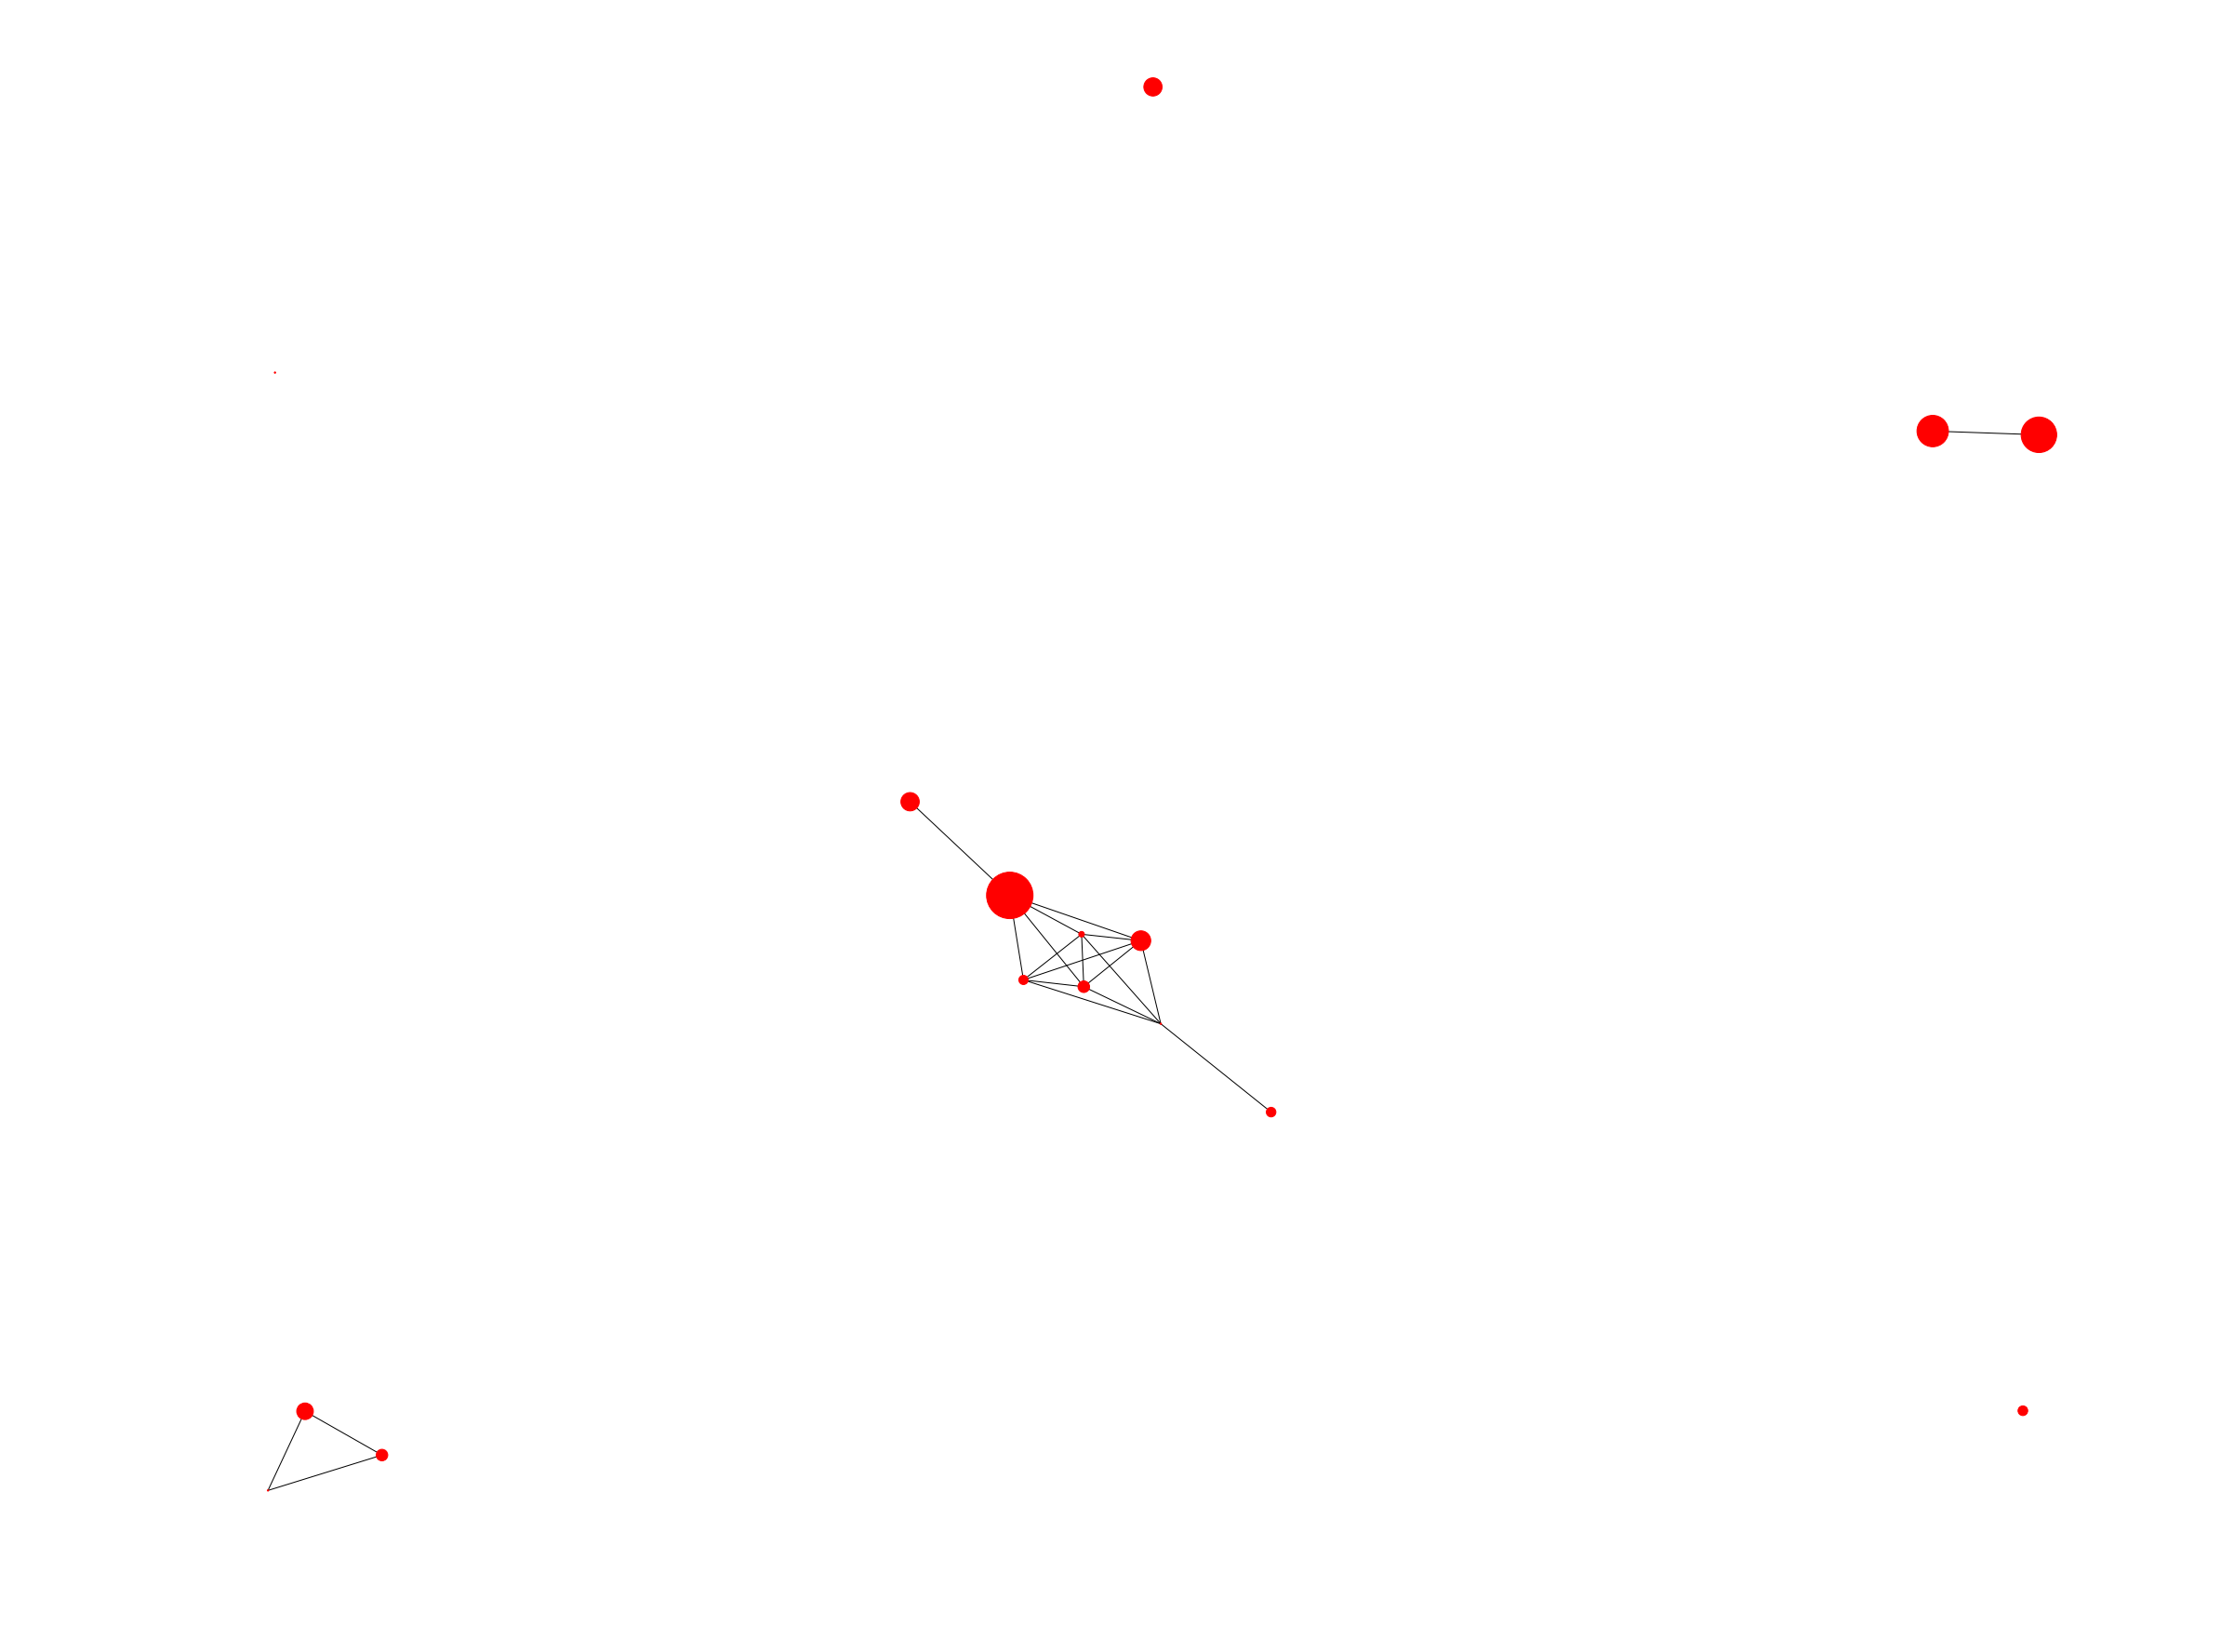

In [7]:
def listedEiggHotelRatings():
    hotelRatings = {}
    
    # *************  FORMAT  ***************
    # hotelRatings["NameOfHotel"] = [TripAdvisor/AirBnb Mean, Google Review Mean, FB likes]
    # =>  UNIQUE ID = [Populist rating, Accessibility rating, Popularity rating]
    
    #CAUTION ON SOCKPUPPETING
    
    hotelRatings["Tigh an Sithean – camping cabins & log cabins"] = [(3.75,4),(0,0),0]
    hotelRatings["Lageorna"] = [(4.87,75),(5,16),725]
    hotelRatings["Tophouse"] = [(0,0),(0,0),0]
    hotelRatings["Amazing Eigg Shed"] = [(4.91,105),(0,0),0]
    hotelRatings["Eigg Organics"] = [(1,1),(4.80,14),0]
    hotelRatings["Kildonnan house"] = [(4.89,36),(5,5),279]
    hotelRatings["Laig Caravan"] = [(4.9,39),(0,0),333]
    hotelRatings["Glebe Barn"] = [(4.84,45),(4.9,31),440]
    hotelRatings["The Smiddy"] = [(5,16),(4.5,2),0]
    hotelRatings["Sweeney's Bothy"] = [(5,57),(0,0),0]
    hotelRatings["Laig Beach Bothy"] = [(0,0),(0,0),0]
    hotelRatings["Eigg Camping Pods"] = [(0,0),(5,10),705]
    hotelRatings["Tigh Eilidh"] = [(5,16),(4,1),34]
    hotelRatings["Eigg Eco Centre"] = [(0,0),(5,3),0]
    hotelRatings["Clanranald college"] = [(0,0),(0,0),0]
    hotelRatings["Howlin Cottege"] = [(0,0),(5,2),0]
    
    return hotelRatings

def scoreIndividualHotelRating(rating, reviewMax, fbMax):
    tripAdvisor, googleReview, facebookLiked = rating
    
    tripAdvisorStars, numTripAdvisorRatings = tripAdvisor
    googleStars, numGoogleReviews = googleReview
    
    overallReviews = (numTripAdvisorRatings + numGoogleReviews) / reviewMax
    
    overallUserReview = 0
    
    if overallReviews != 0:
        overallUserReview = (numTripAdvisorRatings*tripAdvisorStars + numGoogleReviews*googleStars)/(overallReviews*reviewMax)
        
    fbReviews = facebookLiked / fbMax
    
    #print(1+(10**(0.2*overallUserReview + 0.6*overallReviews + 0.2*fbReviews)))
    return 1+(100**(0.2*overallUserReview + 0.6*overallReviews + 0.2*fbReviews))
    print(numTripAdvisorRatings,numGoogleReviews)
    return 10*(numTripAdvisorRatings+numGoogleReviews)+100

def mapHotelLocationToScore():
    hotelLocations = listedEiggHotels().keys()
    (rMax,fbMax) = gatherStatistics()
    hotelRatings = list(map(lambda x: scoreIndividualHotelRating(x, rMax,fbMax),listedEiggHotelRatings().values()))
    hotelWScore = list(zip(hotelLocations,hotelRatings))
    return hotelWScore

def gatherStatistics():
    ratings = listedEiggHotelRatings().values()
    reviewMax =  max([x[1][1]+x[0][1] for x in ratings])
    fbMax = max([x[2] for x in ratings])
    
    return reviewMax, fbMax

def buildGraph():
    hotels = cleanResidences(listedEiggHotels())
    scoredLocations = mapHotelLocationToScore()
    
    scoredLocations = list(map(lambda x: [x[0].split(","),x[1]],scoredLocations))
    scoredLocations = list(map(lambda x: [(float(x[0][0]),float(x[0][1])),x[1]],scoredLocations))
    
    G,scores = graphASetByObservations(scoredLocations)
    #print(len(hotels),len(scoredLocations)) #NOTHING TOO CLOSE SO ITS OK
    return G,scores

G,scores = buildGraph()
nx.draw(G, node_size = [s for s in scores])